In [ ]:
import pandas as pd
import numpy as np
import talib as ta
import tensorflow as tf
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")
tf.config.list_physical_devices('GPU')
tf.config.list_physical_devices('CPU')
matplotlib.rcParams['font.family']= 'Songti SC'  # 使用黑体-简
matplotlib.rcParams['axes.unicode_minus'] = False # 解决负号显示问题

In [544]:
df = pd.read_csv('stock.csv',index_col='date', parse_dates=True)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 129428 entries, 2017-10-26 12:00:00 to 2025-03-14 21:30:00
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    129428 non-null  float64
 1   close   129428 non-null  float64
 2   low     129428 non-null  float64
 3   high    129428 non-null  float64
 4   volume  129428 non-null  float64
 5   count   129428 non-null  int64  
 6   amount  129428 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 7.9 MB


,open,close,low,high,volume,count,amount
date,,,,,,,
2017-10-26 12:00:00,230.00,296.67,230.00,299.40,148701.673027,52,575.1466
2017-10-26 12:30:00,296.28,290.00,290.00,296.68,164207.334934,48,557.3589
2017-10-26 13:00:00,291.43,292.69,289.01,294.00,448773.263215,49,1541.4099
2017-10-26 13:30:00,290.29,294.07,290.29,296.36,405905.625453,43,1379.0684
2017-10-26 14:00:00,293.65,292.30,292.00,293.65,317590.616442,43,1085.3961


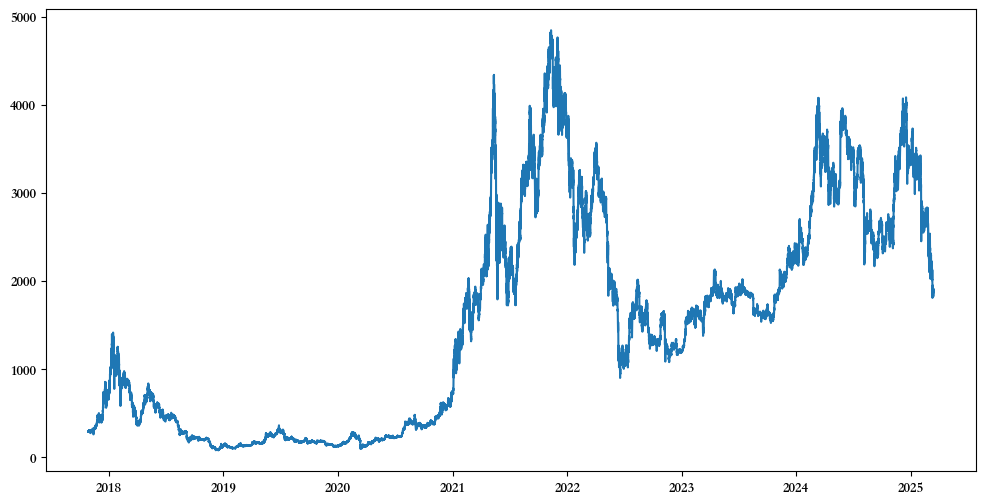

In [545]:
plt.figure(figsize=(12,6))
plt.plot(df['close'], label='Close Price')
plt.show()

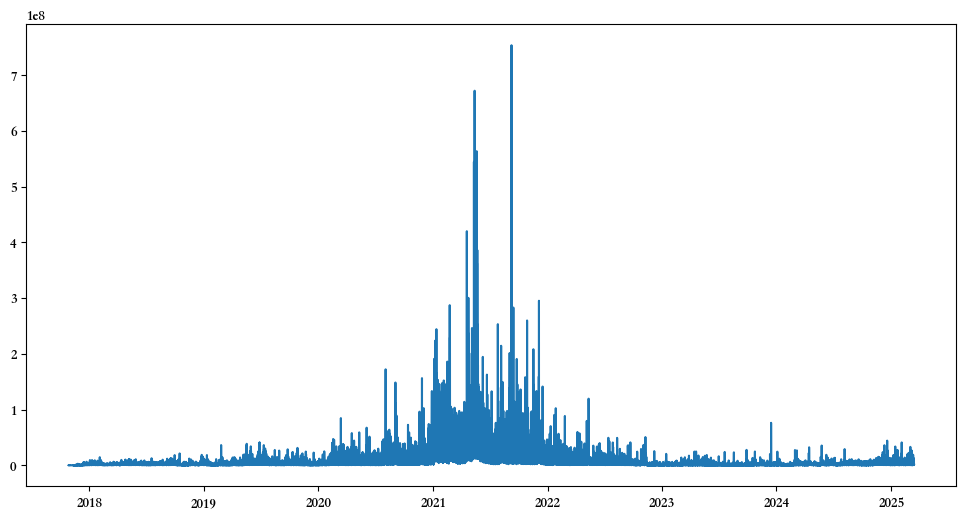

In [546]:
plt.figure(figsize=(12,6))
plt.plot(df['volume'], label='Volume')
plt.show()

'\n多峰分布\n右偏分布 右侧稀疏，尾部延展到较高的价格区间\n'

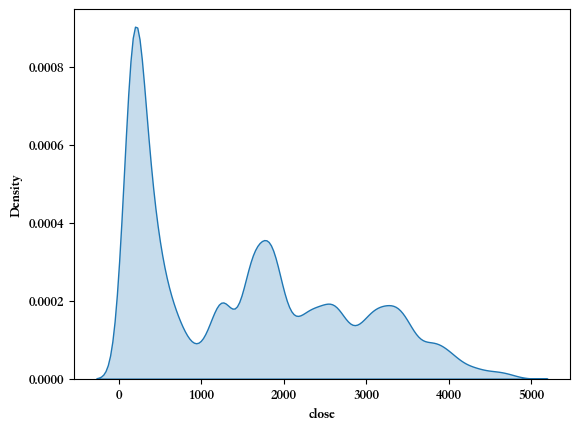

In [547]:
"""收盘价的概率密度分布图"""
sns.kdeplot(df['close'], fill=True)
"""
多峰分布
右偏分布 右侧稀疏，尾部延展到较高的价格区间
"""

/opt/anaconda3/envs/python312/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


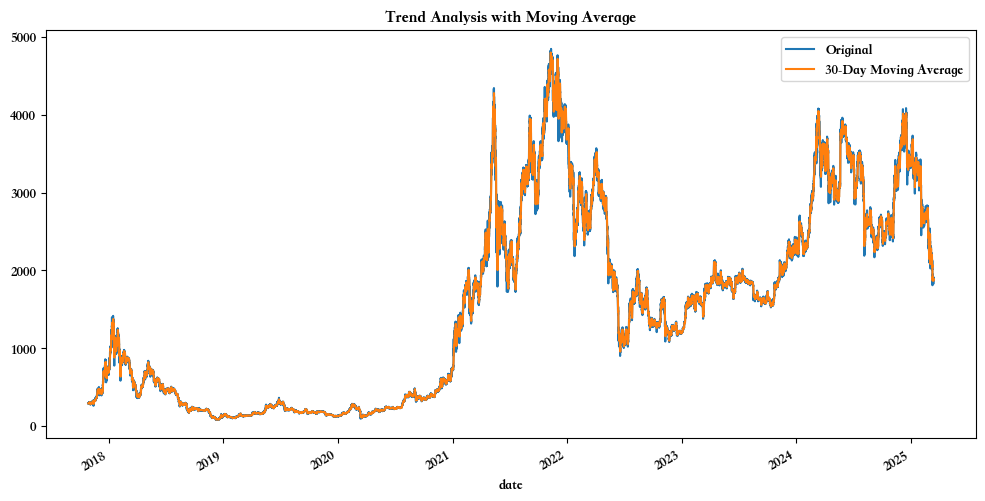

In [548]:
"""趋势分析"""
window_size =30
df['ma_trend'] = df['close'].rolling(window=window_size).mean()
plt.figure(figsize=(12,6))
plt.plot(df['close'],label='Original')
df['ma_trend'].plot(label=f'{window_size}-Day Moving Average')
plt.legend()
plt.title('Trend Analysis with Moving Average')
plt.show()

<Figure size 2400x900 with 0 Axes>

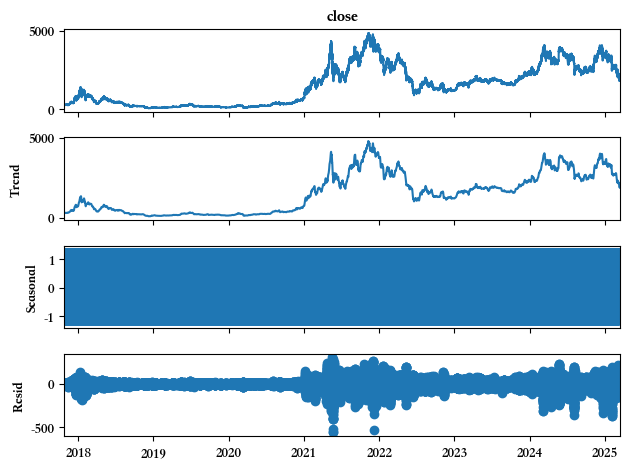

'\n残差分析：\n2021-2023年，残差分析波动明显\n'

In [549]:
result = sm.tsa.seasonal_decompose(df['close'], model='additive', period=96) 
# 可视化分解结果
plt.figure(figsize=(24,9))
result.plot()
plt.tight_layout()
plt.show()
"""
残差分析：
2021-2023年，残差分析波动明显
"""

In [550]:
df_2021_2023 = df[df.index.year.isin([2021, 2022])]
df_2021_2023.head()

,open,close,low,high,volume,count,amount,ma_trend
date,,,,,,,,
2021-01-01 00:00:00,736.01,732.88,730.65,737.18,7.851867e+06,10955,10697.571662,740.972333
2021-01-01 00:30:00,733.03,727.32,725.00,733.54,8.237999e+06,10410,11308.818034,740.643667
2021-01-01 01:00:00,727.19,741.53,726.60,742.97,1.348534e+07,17747,18296.616947,740.709000
2021-01-01 01:30:00,741.52,737.13,735.44,742.53,4.480329e+06,7395,6058.610073,740.666667
2021-01-01 02:00:00,737.14,737.97,735.28,738.58,2.939050e+06,5878,3987.672267,740.604000


In [551]:
# 综合异常检测方案
def detect_anomalies(series, window=24, z_threshold=4.5, iqr_scale=0.2):
    """多方法异常检测"""
    # 1. 滑动窗口Z-score
    rolling_mean = series.rolling(window=window, min_periods=12).mean()
    rolling_std = series.rolling(window=window, min_periods=12).std()
    z_scores = (series - rolling_mean) / (rolling_std + 1e-6)
    z_anomalies = np.abs(z_scores) > z_threshold
    # 2. IQR方法
    q1 = series.rolling(window=window, min_periods=12).quantile(0.25)
    q3 = series.rolling(window=window, min_periods=12).quantile(0.75)
    iqr = q3 - q1
    # iqr_bounds = (q1 - iqr_scale * iqr, q3 + iqr_scale * iqr)
    iqr_anomalies = (series < (q1 - iqr_scale*iqr)) | (series > (q3 + iqr_scale*iqr))
    # 3. 3σ原则
    # sigma = series.rolling(window=window, min_periods=1).std()
    # sigma_bounds = (series.rolling(window=window, min_periods=1).mean() - 3*sigma, series.mean() + 3*sigma)

    # 4. 分位数过滤（排除极端正常波动）
    # price_range = series.quantile(0.999) - series.quantile(0.001)
    # range_anomalies = (series.diff().abs() > 0.15*price_range)

    # 阶段三：波动率调整 ------------------------------------------
    # GARCH波动率估计
    volatility = series.pct_change().rolling(48).std() * np.sqrt(48)  # 日波动率
    volatility_factor = np.where(volatility > 0.2, 1.5, 1.0)  # 高波动时段放宽阈值
    # 综合标记异常
    # anomalies = (
    #     (z_scores.abs() > z_threshold) |
    #     (series < iqr_bounds[0]) | (series > iqr_bounds[1]) |
    #     (series < sigma_bounds[0]) | (series > sigma_bounds[1])
    # )
    # anomalies = z_anomalies & iqr_anomalies & ~range_anomalies
    anomalies = (z_anomalies & iqr_anomalies) * volatility_factor
    print("索引一致性检查：")
    print(f"原始数据长度：{len(series)}")
    print(f"异常标记长度：{len(anomalies)}")
    print(f"索引匹配度：{series.index.equals(anomalies.index)}")
    # 修正索引对齐（如果需要）
    aligned_anomalies = anomalies.astype(bool).fillna(False).reindex(series.index, fill_value=False)
    return aligned_anomalies

def max_consecutive_anomalies(anomalies):
    """计算最大连续异常持续时间"""
    return anomalies.astype(int).groupby(~anomalies.astype(bool)).sum().max()
# 可视化修正
def plot_anomalies(series, anomalies, title):
    plt.figure(figsize=(16, 6))
    # 主序列
    ax = series.plot(label='Normal', alpha=0.8,linewidth=1.2)
    
    # 异常点（确保索引对齐）
    anomaly_points = series.loc[anomalies]
    anomaly_points.plot(
        ax=ax,
        style='D',
        markersize=12,
        color='#FF4500',  # 使用更醒目的橙色
        label='Anomaly',
        alpha=0.9
    )
    # 添加异常密度热力图
    if len(anomaly_points) > 0:
        sns.kdeplot(
            x=anomaly_points.index.astype(np.int64), 
            y=anomaly_points.values,
            cmap='Reds',
            fill=True,
            alpha=0.2,
            ax=ax
        )
    plt.title(f'{title} Anomaly Detection\n(异常率：{anomalies.mean():.2%})', pad=20)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 添加统计信息框
    stats_text = f"""异常点统计：
    • 总数：{anomalies.sum()}
    • 异常率：{anomalies.mean():.2%}
    """
    
    plt.annotate(stats_text, 
                xy=(0.78, 0.85), 
                xycoords='axes fraction',
                bbox=dict(boxstyle="round", fc="white", ec="#999999", alpha=0.8))
    plt.show()

## 异常检测方法对比
| 方法 | 优点 | 缺点 | 适用场景|
| ---- | ---- | ---- | ---- |
| 滑动Z-score | 适应趋势变化 | 窗口大小敏感 | 短期波动分析 |
| IQR | 抗极端值干扰 | 忽略时间序列特性 | 静态分布分析 |
| 3σ原则 | 理论基础强 | 要求正态分布 | 高斯分布数据 |
| STL分解 | 分离趋势/季节成分	 | 计算复杂度高 | 周期性明显的数据 |
| 孤立森林 | 处理高维数据 | 需要调参 | 复杂模式识别 |




索引一致性检查：
原始数据长度：129428
异常标记长度：129428
索引匹配度：True
索引一致性检查：
原始数据长度：129428
异常标记长度：129428
索引匹配度：True


/opt/anaconda3/envs/python312/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8226 (\N{BULLET}) missing from font(s) Songti SC.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/python312/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8226 (\N{BULLET}) missing from font(s) Songti SC.
  fig.canvas.print_figure(bytes_io, **kw)


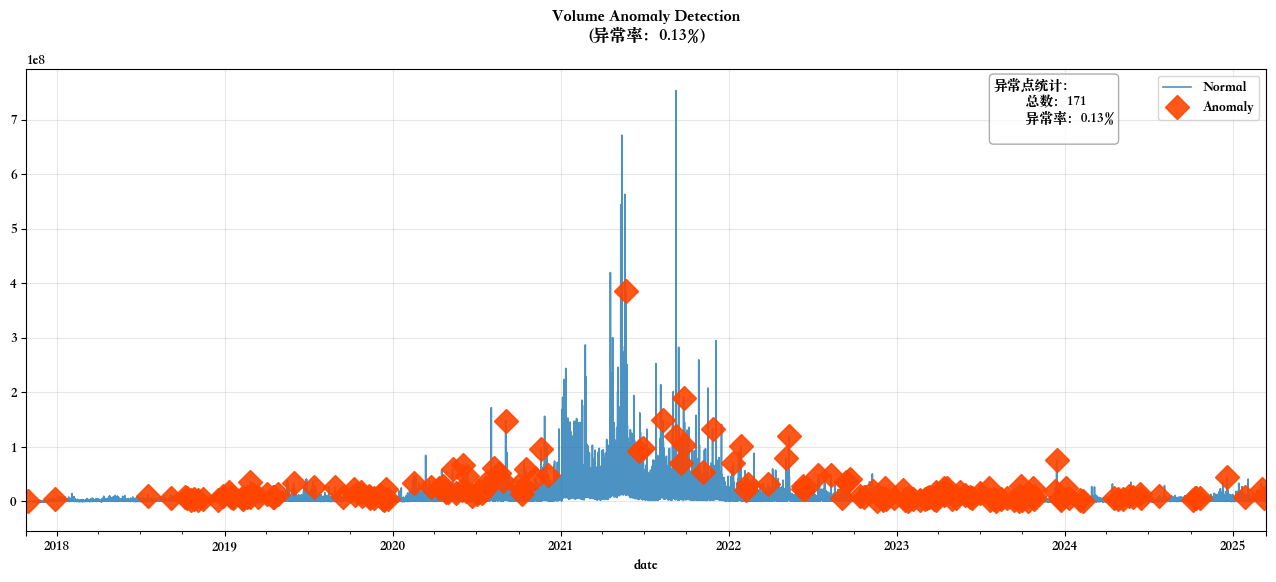


Volume异常点统计：
总数：171
异常率：0.13%

随机异常样本：
                        open     high      low    close        volume
date                                                                 
2019-12-17 02:00:00   141.13   141.25   135.19   135.19  5.321538e+06
2022-06-11 16:30:00  1662.31  1663.49  1576.39  1577.24  2.876605e+07
2018-09-05 17:30:00   283.80   284.02   266.66   267.05  6.499351e+06


In [552]:
close_anomalies = detect_anomalies(df['close'])
volume_anomalies = detect_anomalies(df['volume'])

# plot_anomalies(df['close'], close_anomalies, 'Close Price')
plot_anomalies(df['volume'], volume_anomalies, 'Volume')

# print("Close Price异常点统计：")
# print(f"总数：{close_anomalies.sum()}")
# print(f"异常率：{close_anomalies.mean():.2%}")
if volume_anomalies.sum() > 0:
    print("\nVolume异常点统计：")
    print(f"总数：{volume_anomalies.sum()}")
    print(f"异常率：{volume_anomalies.mean():.2%}")

# 典型异常样本查看
sample_anomalies = df[close_anomalies].sample(3, random_state=42)
print("\n随机异常样本：")
print(sample_anomalies[['open', 'high', 'low', 'close', 'volume']])


In [553]:
# from statsmodels.tsa.seasonal import STL

# def stl_residual_anomaly(series, period=24):
#     stl = STL(series, period=period, robust=True)
#     res = stl.fit()
#     return detect_anomalies(res.resid)

# stl_anomalies = stl_residual_anomaly(df['volume'])
# plot_anomalies(df['volume'], stl_anomalies, 'Volume')

/opt/anaconda3/envs/python312/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8226 (\N{BULLET}) missing from font(s) Songti SC.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/python312/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8226 (\N{BULLET}) missing from font(s) Songti SC.
  fig.canvas.print_figure(bytes_io, **kw)


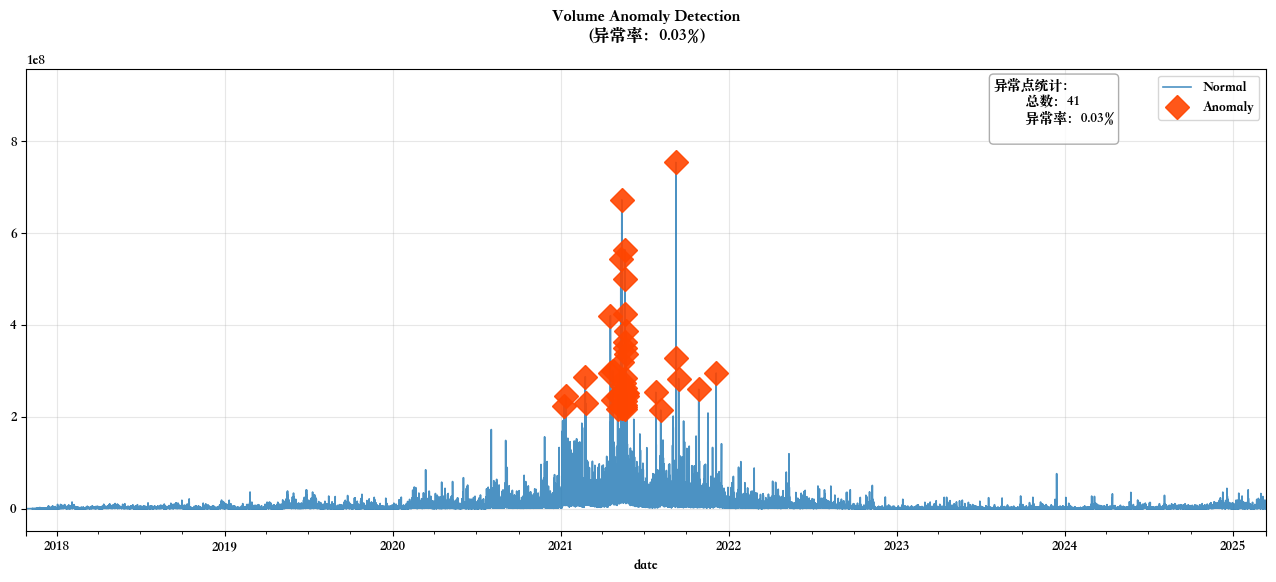

In [554]:
# 使用孤立森林增强检测
from sklearn.ensemble import IsolationForest

def iso_forest_detect(series):
    model = IsolationForest(
        contamination=0.0005,  # 预期异常比例
        random_state=42
    )
    X = series.values.reshape(-1,1)
    return model.fit_predict(X) == -1
iso_forest_anomalies = iso_forest_detect(df['volume'])
plot_anomalies(df['volume'], iso_forest_anomalies, 'Volume')
data = df.copy()
data.loc[iso_forest_anomalies]=np.nan
data.loc[iso_forest_anomalies] = data.loc[iso_forest_anomalies].interpolate() 


In [555]:
# 使用GARCH模型估计波动率
from arch import arch_model

def garch_volatility(series):
    model = arch_model(series*100, vol='Garch', p=1, q=1)
    fit = model.fit(disp='off')
    return fit.conditional_volatility / 100  # 还原尺度

df['volatility'] = garch_volatility(df['close'])

print(df.head())

/opt/anaconda3/envs/python312/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.519e+10. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.0001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


                       open   close     low    high         volume  count  \
date                                                                        
2017-10-26 12:00:00  230.00  296.67  230.00  299.40  148701.673027     52   
2017-10-26 12:30:00  296.28  290.00  290.00  296.68  164207.334934     48   
2017-10-26 13:00:00  291.43  292.69  289.01  294.00  448773.263215     49   
2017-10-26 13:30:00  290.29  294.07  290.29  296.36  405905.625453     43   
2017-10-26 14:00:00  293.65  292.30  292.00  293.65  317590.616442     43   

                        amount  ma_trend   volatility  
date                                                   
2017-10-26 12:00:00   575.1466       NaN  1196.213735  
2017-10-26 12:30:00   557.3589       NaN  1342.854510  
2017-10-26 13:00:00  1541.4099       NaN  1349.240448  
2017-10-26 13:30:00  1379.0684       NaN  1346.664948  
2017-10-26 14:00:00  1085.3961       NaN  1345.343720  


In [ ]:
def create_features(df: pd.DataFrame):
    """特征值提取"""
    df['SMA'] = df['close'].rolling(window=20).mean()
    df['EMA20'] = df['close'].ewm(span=20, adjust=False).mean()
    df['MACD'] = df['close'].ewm(span=12, adjust=False).mean() - df['close'].ewm(span=26, adjust=False).mean()
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_Histogram'] = df['MACD'] - df['Signal']
    df['RSI'] = ta.RSI(df['close'], timeperiod=14)
    df['UpperBB'],df['MiddleBB'],data['LowerBB'] = ta.BBANDS(df['close'], timeperiod=20)
    df['ATR'] = ta.ATR(df['high'], df['low'], df['close'], timeperiod=14)
    df['Volatility'] = df['ATR'] / df['close']

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dense, Dropout

